### Goal:

#### Here, we will try to predict one year of stock price of Microsoft.

##### **The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable.**

## Importing basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error 

warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

## Collecting data

In [2]:
data = pd.read_csv('MSFT_Stock_Market_final_data.csv', parse_dates= True, index_col = 'Date')

In [3]:
new_data = data.copy()
new_data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Monthly_moving_average,Expanding_mean
Date,,,,,,,,,,,,,,,
2012-01-03,26.76,2012,1,1,3,1,3,0,0,0,0,0,0,0.0,0.000
2012-01-04,27.40,2012,1,1,4,2,4,0,0,0,0,0,0,0.0,27.080
2012-01-05,27.68,2012,1,1,5,3,5,0,0,0,0,0,0,0.0,27.280
2012-01-06,28.10,2012,1,1,6,4,6,0,0,0,0,0,0,0.0,27.485
2012-01-09,27.74,2012,1,2,9,0,9,0,0,0,0,0,0,0.0,27.536


### Splitting Data

We will use the last year as our validation data and train the model based on the past data. Basically we will generate one year of stock market data based on historical data of the previous five years.

In [4]:
#Training set
train = new_data[ : '2017-01-01']

#Validation set
val = new_data['2017-01-01' : ]

## Model Building

**First we will test on two base-line models with our dataset.**

- **Linear regression**
- **K-Nearest Neighbors**


After this we will move on to some advanced models.

In [5]:
# Splitting into x and y sets

x_train = train.drop('Close', axis=1)
y_train = train['Close']

x_val = val.drop('Close', axis=1)
y_val = val['Close']


In [6]:
#Scaling the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)

#Not fitting validation set as it will cause data leakage
x_val_scaled = scaler.transform(x_val)

### 1. Linear Regression

The most basic machine learning algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.

The equation for linear regression can be written as:

<center><img src = 'images/linear_regression.png' height = 200 ></center>

In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(x_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
prediction = lr.predict(x_val_scaled)

regression_forecast = pd.DataFrame(prediction, index = val.index, columns = ['Prediction'])

rmse = np.sqrt(mean_squared_error(y_val, regression_forecast['Prediction']))# Calculating the root-mean squared error

print(rmse)

9.235566852555191


The RMSE score for our Linear model is quite good. Let's plot it against the actual validation set.

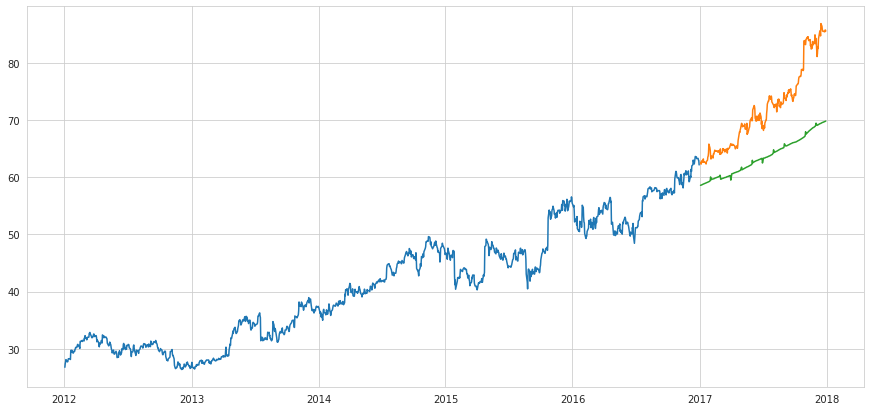

In [9]:
plt.figure(figsize = (15,7))
plt.plot(train['Close'])
plt.plot(val['Close'])
plt.plot(regression_forecast['Prediction'])
plt.show()

Linear regression is a simple technique and quite easy to interpret.

It has caught the rising trend of the stock price but fails to capture the seasonality. Instead of taking into account the previous values from the point of prediction, the model will consider the value from the same date a month ago, or the same date/month a year ago.

### 2. K-Nearest Neighbors



Another interesting base-line algorithm that can be used in time-series datasets is KNN (K-Nearest Neighbours). 

Based on the independent variables, kNN finds the similarity between new data points and old data points.

In [10]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 5)

knn.fit(x_train_scaled, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [11]:
prediction = knn.predict(x_val_scaled)

knn_forecast = pd.DataFrame(prediction, index = val.index, columns = ['Prediction'])

rmse = np.sqrt(mean_squared_error(y_val, knn_forecast['Prediction']))# Calculating the root-mean squared error

print(rmse)

17.170670586741984


The RMSE score of our KNN algorithm is higher than Linear Regression. Let's plot it against the validation data.

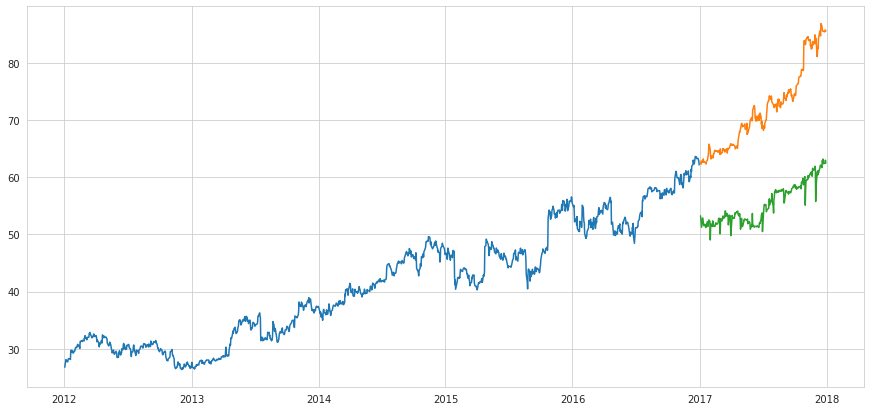

In [12]:
plt.figure(figsize = (15,7))
plt.plot(train['Close'])
plt.plot(val['Close'])
plt.plot(knn_forecast['Prediction'])
plt.show()

Just like Linear Regression, KNN also failed to capture the seasonality. It has just captured the increasing trend according to past data.



In coclusion , regression algorithms doesn't quite perform on time-series data and hence we need to apply some other advanced models and techniques.

#####   

**Now, We are going to test three models that are specifically designed for time-series analysis and prediction.**

- **Auto ARIMA (Autoregressive integrated moving average)**
- **Prophet**
- **LSTM (Long-Short term Memory)**


**The Evaluation metric for our models will be 'Root-Mean Squared Error'**

### 1. Auto ARIMA

ARIMA models take into account the past values to predict the future values.

Parameter tuning for ARIMA is time consuming. So we will use Auto ARIMA which automatically selects the best combination of (p,q,d) that provides the least error.

**Q. What are p, q, d?**

- p (past values used for forecasting the next value)
- q (past forecast errors used to predict the future values)
- d (order of differencing)

[Here](https://datafai.com/auto-arima-using-pyramid-arima-python-package/) is great article on implementation of Auto-Arima.

In [13]:
training = train['Close']
validation = val['Close']

If the following import gives an error, just run !pip install pyramid-arima to install the relevant dependencies.

In [14]:
from pyramid.arima import auto_arima

arima = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
"""
Model within ranges of defined start_p, max_p, start_q, max_q ranges. Auto ARIMA finds the best combination within this range.
Seasonal = True means that the given time-series subjects to seasonal trend.

"""

arima.fit(training)

prediction = arima.predict(n_periods = val.shape[0]) # Predicting one year of values

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2409.526, BIC=2435.160, Fit time=27.636 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3232.928, BIC=3243.181, Fit time=0.400 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2862.235, BIC=2882.743, Fit time=2.740 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2411.667, BIC=2432.175, Fit time=11.444 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2415.471, BIC=2446.232, Fit time=18.927 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3172.530, BIC=3193.037, Fit time=5.864 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2411.286, BIC=2442.047, Fit time=54.079 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2417.777, BIC=2453.665, Fit time=51.250 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2409.745, BIC=2440.506, Fit time=19.704 seconds
Fit ARIMA: order=(1, 1

In [15]:
arima_forecast = pd.DataFrame(prediction, index = val.index, columns = ['Prediction'])

rmse = np.sqrt(mean_squared_error(val['Close'], arima_forecast['Prediction']))# Calculating the root-mean squared error

print(rmse)

6.354760006177382


The RMSE score of our Auto ARIMA model is quite good. Let's plot the values against our validation data, i.e one year of stock data.

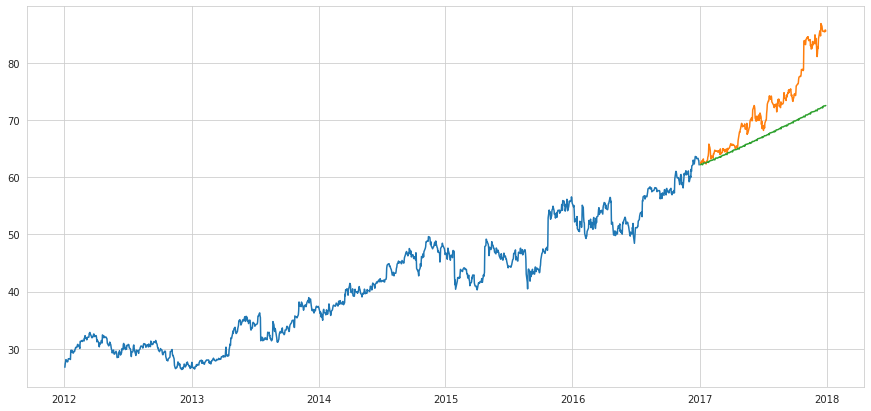

In [16]:
plt.figure(figsize = (15,7))
plt.plot(train['Close'])
plt.plot(val['Close'])
plt.plot(arima_forecast['Prediction'])
plt.show()

As said earlier, an auto ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series, but does not focus on the seasonal part. 

### 2. Prophet

Prophet, designed and pioneered by Facebook, is a time series forecasting library that requires no data preprocessing and is extremely simple to implement.

Prophet tries to capture the seasonality in the past data and works well when the dataset is large.

Learn more about Prophet by visiting this [link](https://towardsdatascience.com/a-quick-start-of-time-series-forecasting-with-a-practical-example-using-fb-prophet-31c4447a2274).

In [17]:
from fbprophet import Prophet

"""
Prophet model expects the dataframe to have two columns 
1. The target variable(in our case 'Close')
2. The Date column

Both these columns need to have a specific name for this model to work.

Date = ds, target = y

"""

df = pd.DataFrame(columns=['Date', 'Close']) #Creating new dataframe

df['Date'] = new_data.index.values
df['Close'] = new_data['Close'].values
df.index = df.Date

df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)# Renaming according to model usage

#train and validation
df_train = df[:'2017-01-01']
df_valid = df['2017-01-01':]

# Model training
prophet = Prophet()

prophet.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
prophet_forecast = prophet.make_future_dataframe(periods=len(df_valid))

predictions = prophet.predict(prophet_forecast)

In [19]:
predictions.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-03,29.762365,29.237051,33.233681,29.762365,29.762365,1.585125,1.585125,1.585125,0.603235,0.603235,0.603235,0.981890,0.981890,0.981890,0.0,0.0,0.0,31.347489
1,2012-01-04,29.778951,29.175302,33.398794,29.778951,29.778951,1.470845,1.470845,1.470845,0.623132,0.623132,0.623132,0.847712,0.847712,0.847712,0.0,0.0,0.0,31.249796
2,2012-01-05,29.795538,29.015020,33.207850,29.795538,29.795538,1.341740,1.341740,1.341740,0.624815,0.624815,0.624815,0.716925,0.716925,0.716925,0.0,0.0,0.0,31.137278


In [20]:
prophet_forecast['y'] = predictions['yhat']

In [21]:
rmse = np.sqrt(mean_squared_error(val['Close'], prophet_forecast['y'][-len(val):]))# Calculating the root-mean squared error

print(rmse)

12.832206276340557


The RMSE score of our Prophet model is a bit higher than ARIMA Model. Let's plot it to see the difference.

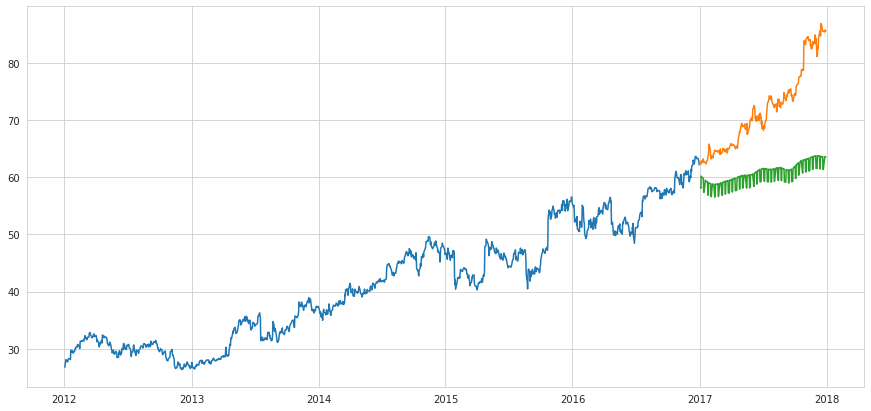

In [22]:
prophet_forecast = prophet_forecast[-len(val):]
df_valid['Predictions'] = prophet_forecast['y'].values

plt.figure(figsize = (15,7))
plt.plot(train['Close'])
plt.plot(val['Close'])
plt.plot(df_valid['Predictions'])
plt.show()

Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data.

Stock prices do not have a particular trend or seasonality. It highly depends on what is currently going on in the market and thus the prices rise and fall. Hence forecasting techniques like ARIMA and Prophet would not perform well for this particular problem.

### 3. Long Short Term Memory (LSTM)

LSTM is a neural network technique to predict sequences.

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not.

It has three main gates:

- **Input gate: The input gate adds information to the cell state**
- **Forget gate: It removes the information that is no longer required by the model**
- **Output gate: Output Gate at LSTM selects the information to be shown as output**

Learn more about LSTM's in this wonderful [article](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/).

#### Scaling the data

In [23]:
from sklearn.preprocessing import MinMaxScaler

data_close = new_data['Close'].values

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data_close.reshape(-1,1)) 

#### Splitting the data

In [24]:
# Creating x_train and y_train

"""
Will take past 90 days of data to predict the 91th day stock price.
"""

x_train, y_train = [], []

for i in range(90,len(train)):

    x_train.append(scaled_data[i-90:i])
    y_train.append(scaled_data[i])

x_train, y_train = np.array(x_train), np.array(y_train) # Converting to numpy array

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) # Reshaping


#### Training Model

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

#1st Layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))

#2nd layer
model.add(LSTM(units=50))
model.add(Dropout(0.3))

#Output layer
model.add(Dense(1))

#Model compilation
adam = Adam(lr = 0.01, beta_1 = 0.99, epsilon = 1e-7)
model.compile(loss = 'mean_squared_error', optimizer = adam)

early_stopping = EarlyStopping(monitor = 'loss', patience = 2)
#Training
model.fit(x_train, y_train, epochs = 10, batch_size=1, callbacks =[early_stopping], verbose=1)

Epoch 1/10
1168/1168 [==============================] - 9s 8ms/step - loss: 0.0044
Epoch 2/10
1168/1168 [==============================] - 9s 8ms/step - loss: 0.0013
Epoch 3/10
1168/1168 [==============================] - 9s 8ms/step - loss: 0.0012
Epoch 4/10
1168/1168 [==============================] - 9s 8ms/step - loss: 0.0014
Epoch 5/10
1168/1168 [==============================] - 9s 8ms/step - loss: 0.0012


#### Predicting validation data using 90 days of past data

In [26]:
# Creating a seperate dataframe
inputs = new_data['Close'][len(new_data) - len(val) - 90:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

#Generating validation data
x_val = []
for i in range(90,inputs.shape[0]):
    x_val.append(inputs[i-90:i])

x_val = np.array(x_val)

x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))

#Predicting validation data
predictions = model.predict(x_val)
predictions = scaler.inverse_transform(predictions)

In [27]:
lstm_forecast = pd.DataFrame(predictions, index = val.index, columns = ['Prediction'])

rmse = np.sqrt(mean_squared_error(val['Close'], lstm_forecast['Prediction']))# Calculating the root-mean squared error

print(rmse)

3.5074574955199016


This is a good RMSE score for our LSTM model. Let's plot the predictions.

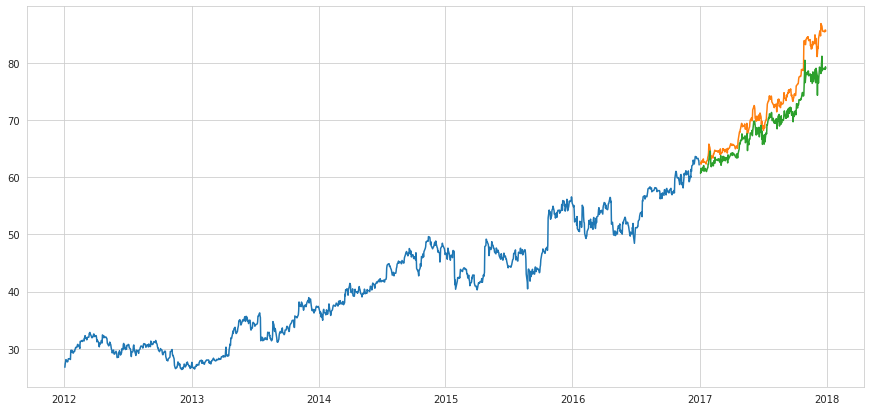

In [28]:
plt.figure(figsize = (15,7))
plt.plot(train['Close'])
plt.plot(val['Close'])
plt.plot(lstm_forecast['Prediction'])
plt.show()

LSTM performed really well on this dataset and was actually able to predict the correct trend of the stock prices.

Stock price is affected by the news about the company and other factors like demonetization or merger/demerger of the companies. There are certain intangible factors as well which can often be impossible to predict beforehand.

Finally, let's save our model for future use.

In [29]:
model.save('model.h5')